# Cleaning the aoi historic service


#### Run this cell to connect to your GIS and get started:

In [9]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.7/site-packages/arcgis/gis/__init__.py:430: UserWarning: You are logged on as greta.carrete_eowilson with an administrator role, proceed with caution.
  self.users.me.username)


## The plan
- [x] For testing purposes the production service will be cloned. 
- [x] Get the number of features in the service
- [x] Check a date field. Eventually it will be the field that informs on when was the last time the area was shared.

<Item title:"aois_historic-dev" type:Feature Layer Collection owner:greta.carrete_eowilson>
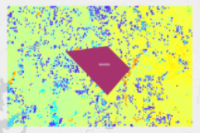

In [10]:
# Item Added From Toolbar
# Title: aois_historic | Type: Feature Service | Owner: greta.carrete_eowilson
item = gis.content.get("ac362edf17cb4c90a15507511e2b9444")
item

In [13]:
item.url

'https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/aois_historic_6a796b684c874ef4bbe2f97b4857bf35/FeatureServer'

In [11]:
cloning_list = [item]

In [12]:
gis.content.clone_items(items=cloning_list)


[<Item title:"aois_historic-dev" type:Feature Layer Collection owner:greta.carrete_eowilson>]

## Working with the cloned item

<Item title:"aois_historic-dev-testing" type:Feature Layer Collection owner:greta.carrete_eowilson>
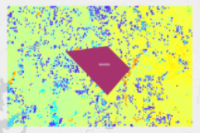

In [17]:
# Item Added From Toolbar
# Title: aois_historic-dev | Type: Feature Service | Owner: greta.carrete_eowilson
item_test = gis.content.get("620cca71b139462992897e0d271ca43e")
item_test

In [15]:
item_test.url

'https://services9.arcgis.com/IkktFdUAcY3WrH25/arcgis/rest/services/aois_historic_e2928a09aa16480e84aa0a33fa850b6d/FeatureServer'

In [119]:
flayer = item_test.layers[0]
fset = flayer.query() #querying without any conditions returns all the features
sdf = fset.sdf
sdf.head()

,OBJECTID,hash_id,population_sum,land_cover_majority,climate_regime_majority,number_of_mammals,number_of_amphibians,number_of_birds,number_of_reptiles,percentage_protected,...,Creator,EditDate,Editor,name,QueriedDate,Shape__Area_2,Shape__Length_2,Shape__Area_3,Shape__Length_3,SHAPE
0,1,e381e62e020ac5824d0ca09e2b2df455d62d907b,None,None,None,4.0,None,None,None,None,...,greta.carrete_eowilson,2021-09-20 10:17:53.134000063,greta.carrete_eowilson,None,NaT,None,None,5.912949e+09,314187.245145,"{""rings"": [[[-733239.051317414, 5308341.375593..."
1,2,67b2b8c24d3d4d7512a0106616abf3172e622d8c,None,None,None,NaN,None,None,None,None,...,greta.carrete_eowilson,2021-09-20 10:05:16.894000053,greta.carrete_eowilson,None,NaT,None,None,3.155591e+10,727886.293679,"{""rings"": [[[-496838.986203923, 5334127.681686..."
2,3,67b2b8c24d3d4d7512a0106616abf3172e622d8c,None,None,None,NaN,None,None,None,None,...,greta.carrete_eowilson,2021-09-20 10:05:16.894000053,greta.carrete_eowilson,None,NaT,None,None,NaN,NaN,NaN
3,4,67b2b8c24d3d4d7512a0106616abf3172e622d8c,None,None,None,5.0,None,None,None,None,...,greta.carrete_eowilson,2021-09-20 10:18:41.546999931,greta.carrete_eowilson,None,NaT,None,None,NaN,NaN,NaN
4,5,67b2b8c24d3d4d7512a0106616abf3172e622d8c,None,None,None,NaN,None,None,None,None,...,greta.carrete_eowilson,2021-09-20 10:05:16.894000053,greta.carrete_eowilson,None,NaT,None,None,NaN,NaN,NaN


### Checking the number of features in the service

In [120]:
sdf.shape

(80, 29)

### Getting the threshold date to delete unused features

In [106]:
import datetime
import numpy as np
current = datetime.date.today()
first = current.replace(day=1)
lastMonth = np.datetime64(first - datetime.timedelta(days=1))
lastMonth

numpy.datetime64('2021-08-31')

In [108]:
# these are the features that have  been queried in the past month
sdf.loc[sdf['QueriedDate'] > lastMonth].QueriedDate.sort_values()

31   2021-08-31 22:00:00
33   2021-09-07 22:00:00
Name: QueriedDate, dtype: datetime64[ns]

In [107]:
# these are the features that have not been queried in the past month
sdf.loc[sdf['QueriedDate'] < lastMonth].QueriedDate.sort_values()

35   2021-07-31 22:00:00
36   2021-08-11 22:00:00
30   2021-08-28 22:00:00
32   2021-08-29 22:00:00
Name: QueriedDate, dtype: datetime64[ns]

### Getting the unused features' ObjectID

In [109]:
# We want to delete from the service the features that have not been queried in the past month.
delete_ids = sdf.loc[sdf['QueriedDate'] < lastMonth].OBJECTID.tolist()

In [115]:
# the list of object ids to remove has to be passed as a string.
ids_str = [str(x) for x in delete_ids]

### Deleting the unused features from the service

In [117]:
delete_result = flayer.edit_features(deletes=ids_str)

In [118]:
delete_result

{'addResults': [],
 'updateResults': [],
 'deleteResults': [{'objectId': 32,
   'uniqueId': 32,
   'globalId': None,
   'success': True},
  {'objectId': 34, 'uniqueId': 34, 'globalId': None, 'success': True},
  {'objectId': 37, 'uniqueId': 37, 'globalId': None, 'success': True},
  {'objectId': 38, 'uniqueId': 38, 'globalId': None, 'success': True}]}